In [1]:
import autograd.numpy as np
import seaborn as sns # for plot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False}) # set seaborn style
import matplotlib.pyplot as plt # for plot
from importlib import reload
import heterogeneous_cox
reload(heterogeneous_cox)
from heterogeneous_cox import HGCox
import pickle
from scipy.special import expit
from scipy.stats import multivariate_normal
from scipy.stats import gamma
from scipy.stats import poisson
from scipy.stats import uniform
from scipy.stats import bernoulli
from numpy.polynomial import legendre
import geopandas as gpd
import pandas as pd
import matplotlib.patches as patches

# 1D synthetic data (complete, one example)

In [2]:
number_of_tasks=np.array([1,1,1]).astype(int) # 1 point process, 1 regression and 1 classification
number_of_latent=2
number_of_dimension=1
toy_model = HGCox(number_of_tasks,number_of_latent,number_of_dimension)

In [3]:
X=np.array([100.0])
X_test=np.array([100.0])
theta= np.array([[1,0.02],[2,0.001]])
weight = np.array([[0.9,0.1],[0.5,0.5],[0.1,0.9]])
noise_reg=np.array([0.1])

In [4]:
with open('./1D_data.pickle', 'rb') as handle:
    x_pp,x_reg,y_reg,x_cla,y_cla,f = pickle.load(handle)
with open('./1D_data_test.pickle', 'rb') as handle:
    x_pp_test,x_reg_test,y_reg_test,x_cla_test,y_cla_test,_ = pickle.load(handle)

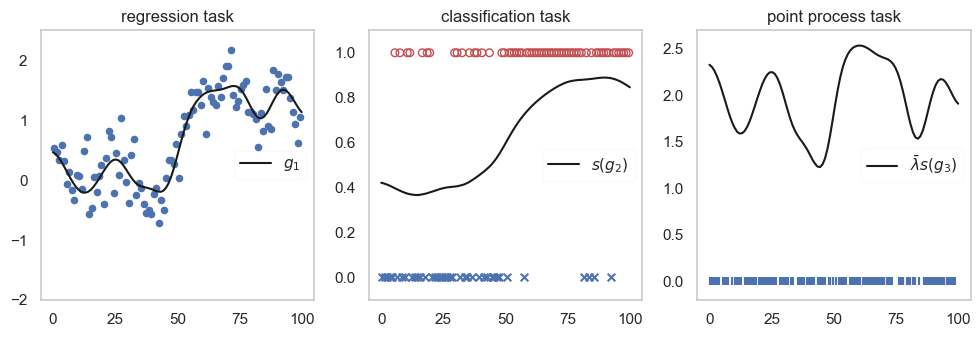

In [5]:
plt.figure(1,figsize=(12,3.5))
axs=plt.subplot(131)
axs.scatter(x_reg,y_reg,s=20)
# axs.scatter(x_reg_test,y_reg_test,s=20)
axs.plot(np.linspace(0,X[0],len(f[1])),f[1],color='k',label=r'$g_1$')
axs.legend(framealpha=0.1,loc='center right')
axs.set_ylim(-2.0,2.5)
axs.set_title('regression task')
axs=plt.subplot(132)
axs.scatter(x_cla[0][y_cla[0]==1],y_cla[0][y_cla[0]==1],facecolors='none',edgecolors='r',s=30)
axs.scatter(x_cla[0][y_cla[0]==-1],y_cla[0][y_cla[0]==-1]+1,marker='x',color='b',s=30)
# axs.scatter(x_cla_test[0][y_cla_test[0]==1],y_cla_test[0][y_cla_test[0]==1],facecolors='none',edgecolors='r',s=30)
# axs.scatter(x_cla_test[0][y_cla_test[0]==-1],y_cla_test[0][y_cla_test[0]==-1]+1,marker='x',color='b',s=30)
axs.plot(np.linspace(0,X[0],len(f[2])),expit(f[2]),color='k',label=r'$s(g_2)$')
axs.legend(framealpha=0.1)
axs.set_ylim(-0.1,1.1)
axs.set_title('classification task')
axs=plt.subplot(133)
axs.scatter(x_pp[0],np.zeros(x_pp[0].shape[0]),marker='|',s=40)
# axs.scatter(x_pp_test[0],np.ones(x_pp_test[0].shape[0]),marker='|',s=40)
axs.plot(np.linspace(0,X[0],len(f[0])),3*expit(f[0]),label=r'$\bar{\lambda}s(g_3)$',color='k')
axs.legend(framealpha=0.1)
axs.set_ylim(-0.2,2.7)
axs.set_title('point process task')
plt.show()

In [6]:
toy_model.set_train_test_data(x_pp, x_reg, y_reg, x_cla, y_cla, X, x_pp_test, x_reg, y_reg_test, x_cla, y_cla_test, X_test)

In [7]:
num_xm=np.array([30]) # inducing points on the plane
xm = np.linspace(0+X[0]/num_xm[0]/2,X[0]-X[0]/num_xm[0]/2,num_xm[0]).reshape(-1,1)   # inducing points on the time axis
toy_model.set_hyperparameters(xm, weight, theta, noise_reg)
num_gq=np.array([100]) # Gaussian quaduature nodes on the time axis
num_pre=np.array([100]) # prediction points on the time axis

In [8]:
%%time
mean_f_pre, cov_f_pre, alpha, logl_train_pp, logl_test_pp, logl_train_reg, logl_test_reg, logl_train_cla, logl_test_cla, hp_list\
= toy_model.MF(num_gq, num_pre, num_iter=500, hp_tune=True)

  0%|                                                   | 0/500 [00:00<?, ?it/s]/Users/zhoufeng/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|█████████████████████████████████████████| 500/500 [00:16<00:00, 29.82it/s]

CPU times: user 1min 8s, sys: 17.1 s, total: 1min 25s
Wall time: 16.8 s


In [9]:
f_sample = multivariate_normal(mean_f_pre,cov_f_pre).rvs(size=100)
f_sample_pp=f_sample[:,:np.prod(num_pre)*number_of_tasks[0]]
f_sample_reg=f_sample[:,np.prod(num_pre)*number_of_tasks[0]:np.prod(num_pre)*sum(number_of_tasks[:2])]
f_sample_cla=f_sample[:,np.prod(num_pre)*sum(number_of_tasks[:2]):]
lamda_ub_sample=gamma(a=alpha, scale=1/np.prod(X)).rvs(size=100)

In [10]:
y_est_pp=lamda_ub_sample.reshape(100,1)*expit(f_sample_pp)
y_est_reg=f_sample_reg
y_est_cla=expit(f_sample_cla)

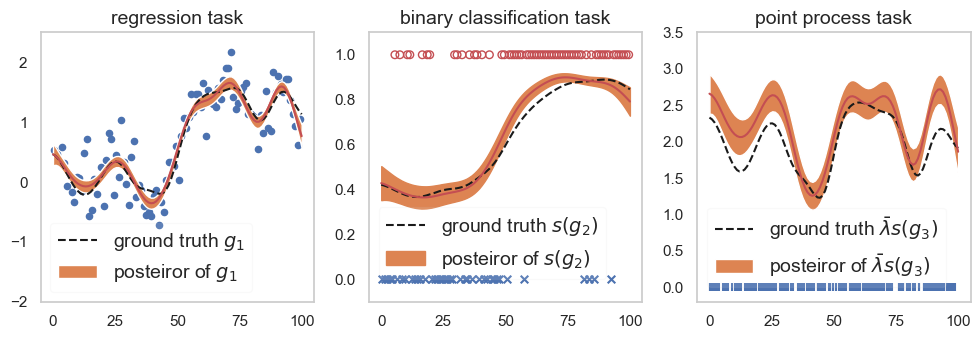

In [11]:
plt.figure(1,figsize=(12,3.5))
axs=plt.subplot(131)
axs.scatter(x_reg,y_reg,s=20)
axs.plot(np.linspace(0,X[0],len(f[1])),f[1],'--',color='k',label=r'ground truth $g_1$')
axs.fill_between(np.linspace(0,X[0],num_pre[0]), np.mean(y_est_reg,axis=0)-np.std(y_est_reg,axis=0), np.mean(y_est_reg,axis=0)+np.std(y_est_reg,axis=0),label=r'posteiror of $g_1$')
axs.plot(np.linspace(0,X[0],num_pre[0]),np.mean(y_est_reg,axis=0),color='r')
axs.legend(framealpha=0.1,loc='lower left',bbox_to_anchor=(0, 0.00),fontsize=14)
axs.set_ylim(-2.0,2.5)
axs.set_title('regression task',fontsize=14)
axs=plt.subplot(132)
axs.scatter(x_cla[0][y_cla[0]==1],y_cla[0][y_cla[0]==1],facecolors='none',edgecolors='r',s=30)
axs.scatter(x_cla[0][y_cla[0]==-1],y_cla[0][y_cla[0]==-1]+1,marker='x',color='b',s=30)
axs.plot(np.linspace(0,X[0],len(f[2])),expit(f[2]),'--',color='k',label=r'ground truth $s(g_2)$')
axs.fill_between(np.linspace(0,X[0],num_pre[0]), np.mean(y_est_cla,axis=0)-np.std(y_est_cla,axis=0), np.mean(y_est_cla,axis=0)+np.std(y_est_cla,axis=0),color=sns.color_palette()[1],label=r'posteiror of $s(g_2)$')
axs.plot(np.linspace(0,X[0],num_pre[0]),np.mean(y_est_cla,axis=0),color='r')
axs.legend(framealpha=0.1,loc='lower left',bbox_to_anchor=(0, 0.05),fontsize=14)
axs.set_ylim(-0.1,1.1)
axs.set_title('binary classification task',fontsize=14)
axs=plt.subplot(133)
axs.scatter(x_pp[0],np.zeros(x_pp[0].shape[0]),marker='|',s=40)
axs.plot(np.linspace(0,X[0],len(f[0])),3*expit(f[0]),'--',color='k',label=r'ground truth $\bar{\lambda}s(g_3)$')
axs.fill_between(np.linspace(0,X[0],num_pre[0]), np.mean(y_est_pp,axis=0)-np.std(y_est_pp,axis=0), np.mean(y_est_pp,axis=0)+np.std(y_est_pp,axis=0),label=r'posteiror of $\bar{\lambda}s(g_3)$')
axs.plot(np.linspace(0,X[0],num_pre[0]),np.mean(y_est_pp,axis=0),color='r')
axs.legend(framealpha=0.1,loc='lower left',bbox_to_anchor=(0, 0.02),fontsize=14)
axs.set_ylim(-0.2,3.5)
axs.set_title('point process task',fontsize=14)
plt.show()

# 1D synthetic data (missing, one example)

In [12]:
with open('./1D_data_missing_gap_complete.pickle', 'rb') as handle: # complete training data
    x_pp,x_reg,y_reg,x_cla,y_cla,f = pickle.load(handle)
with open('./1D_data_missing_gap_complete_test.pickle', 'rb') as handle: # test data
    x_pp_test,x_reg_test,y_reg_test,x_cla_test,y_cla_test,_ = pickle.load(handle)
with open('./1D_data_missing_gap_width_5_0.pickle', 'rb') as handle:   # missing data, gap-width is 5
    x_pp_miss,x_reg_miss,y_reg_miss,x_cla_miss,y_cla_miss = pickle.load(handle)

In [13]:
number_of_tasks=np.array([2,1,1]).astype(int) # 2 point processes, 1 regression and 1 classification
number_of_latent=2
number_of_dimension=1
toy_model = HGCox(number_of_tasks,number_of_latent,number_of_dimension)

In [14]:
X=np.array([100.0])
X_test=np.array([100.0])
theta= np.array([[1,0.02],[2,0.001]])
weight = np.array([[0.9,0.1],[0.1,0.9],[0.3,0.5],[1.0,1.0]])# 2 point processes, 1 regression and 1 classification
noise_reg=np.array([0.1])
lamda_ub=np.array([[3.0],[3.0]]) # ground truth

In [15]:
toy_model.set_train_test_data(x_pp_miss, x_reg_miss, y_reg_miss, x_cla_miss, y_cla_miss, X, x_pp_test, x_reg, y_reg_test, x_cla, y_cla_test, X_test)
num_xm=np.array([10]) # inducing points on the plane
xm = np.linspace(0+X[0]/num_xm[0]/2,X[0]-X[0]/num_xm[0]/2,num_xm[0]).reshape(-1,1)   # inducing points on the time axis
toy_model.set_hyperparameters(xm, weight, theta, noise_reg)
num_gq=np.array([100]) # Gaussian quaduature nodes on the time axis
num_pre=np.array([100]) # prediction points on the time axis

In [16]:
mean_f_pre, cov_f_pre, alpha, logl_train_pp, logl_test_pp, logl_train_reg, logl_test_reg, logl_train_cla, logl_test_cla, hp_list\
        = toy_model.MF(num_gq, num_pre, num_iter=500, hp_tune=True)

100%|█████████████████████████████████████████| 500/500 [00:12<00:00, 38.93it/s]


In [17]:
f_sample = multivariate_normal(mean_f_pre,cov_f_pre).rvs(size=100)
f_sample_pp=f_sample[:,:np.prod(num_pre)*number_of_tasks[0]]
f_sample_reg=f_sample[:,np.prod(num_pre)*number_of_tasks[0]:np.prod(num_pre)*sum(number_of_tasks[:2])]
f_sample_cla=f_sample[:,np.prod(num_pre)*sum(number_of_tasks[:2]):]
lamda_ub_sample=np.array([gamma(a=alpha[i], scale=1/np.prod(X)).rvs(size=100) for i in range(number_of_tasks[0])])
f_sample_pp=np.array([f_sample_pp[:,num_pre[0]*i:num_pre[0]*(i+1)] for i in range(number_of_tasks[0])])

In [18]:
y_est_pp=lamda_ub_sample.reshape(number_of_tasks[0],-1,1)*expit(f_sample_pp)
y_est_reg=f_sample_reg
y_est_cla=expit(f_sample_cla)

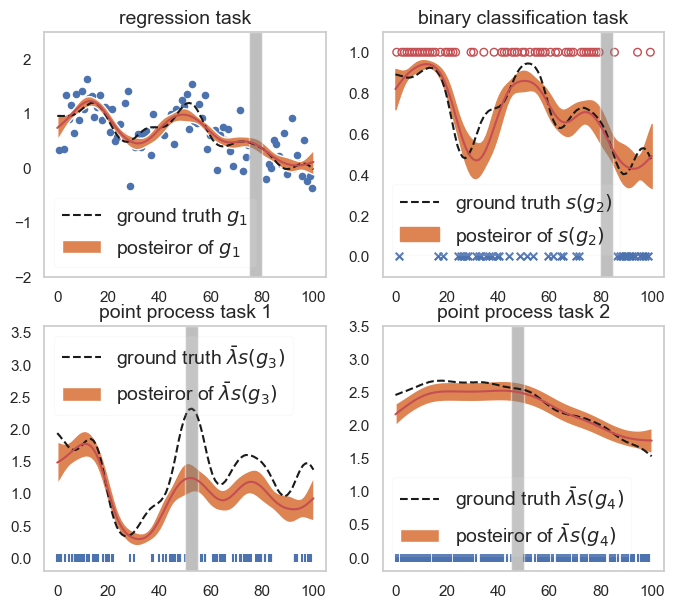

In [19]:
fig=plt.figure(1,figsize=(8,7))
axs=plt.subplot(221)
axs.scatter(x_reg_miss,y_reg_miss,s=20)
axs.plot(np.linspace(0,X[0],len(f[2])),f[2],'--',color='k',label=r'ground truth $g_1$')
axs.fill_between(np.linspace(0,X[0],num_pre[0]), np.mean(y_est_reg,axis=0)-np.std(y_est_reg,axis=0), np.mean(y_est_reg,axis=0)+np.std(y_est_reg,axis=0),label=r'posteiror of $g_1$')
axs.plot(np.linspace(0,X[0],num_pre[0]),np.mean(y_est_reg,axis=0),color='r')
axs.axvspan(75, 80, facecolor='#808080', alpha=0.5)
axs.legend(framealpha=0.1,loc='lower left',bbox_to_anchor=(0, 0.00),fontsize=14)
axs.set_ylim(-2.0,2.5)
axs.set_title('regression task',fontsize=14)
axs=plt.subplot(222)
axs.scatter(x_cla_miss[0][y_cla_miss[0]==1],y_cla_miss[0][y_cla_miss[0]==1],facecolors='none',edgecolors='r',s=30)
axs.scatter(x_cla_miss[0][y_cla_miss[0]==-1],y_cla_miss[0][y_cla_miss[0]==-1]+1,marker='x',color='b',s=30)
axs.plot(np.linspace(0,X[0],len(f[3])),expit(f[3]),'--',color='k',label=r'ground truth $s(g_2)$')
axs.fill_between(np.linspace(0,X[0],num_pre[0]), np.mean(y_est_cla,axis=0)-np.std(y_est_cla,axis=0), np.mean(y_est_cla,axis=0)+np.std(y_est_cla,axis=0),color=sns.color_palette()[1],label=r'posteiror of $s(g_2)$')
axs.plot(np.linspace(0,X[0],num_pre[0]),np.mean(y_est_cla,axis=0),color='r')
axs.axvspan(80, 85, facecolor='#808080', alpha=0.5)
axs.legend(framealpha=0.1,loc='lower left',bbox_to_anchor=(0, 0.05),fontsize=14)
axs.set_ylim(-0.1,1.1)
axs.set_title('binary classification task',fontsize=14)
axs=plt.subplot(223)
axs.scatter(x_pp_miss[0],np.zeros(x_pp_miss[0].shape[0]),marker='|',s=40)
axs.plot(np.linspace(0,X[0],len(f[0])),lamda_ub[0]*expit(f[0]),'--',color='k',label=r'ground truth $\bar{\lambda}s(g_3)$')
axs.fill_between(np.linspace(0,X[0],num_pre[0]), np.mean(y_est_pp[0],axis=0)-np.std(y_est_pp[0],axis=0), np.mean(y_est_pp[0],axis=0)+np.std(y_est_pp[0],axis=0),label=r'posteiror of $\bar{\lambda}s(g_3)$')
axs.plot(np.linspace(0,X[0],num_pre[0]),np.mean(y_est_pp[0],axis=0),color='r')
axs.axvspan(50, 55, facecolor='#808080', alpha=0.5)
axs.legend(framealpha=0.1,loc='upper left',fontsize=14)
axs.set_ylim(-0.2,3.6)
axs.set_title('point process task 1',fontsize=14)
axs=plt.subplot(224)
axs.scatter(x_pp_miss[1],np.zeros(x_pp_miss[1].shape[0]),marker='|',s=40)
axs.plot(np.linspace(0,X[0],len(f[1])),lamda_ub[1]*expit(f[1]),'--',color='k',label=r'ground truth $\bar{\lambda}s(g_4)$')
axs.fill_between(np.linspace(0,X[0],num_pre[0]), np.mean(y_est_pp[1],axis=0)-np.std(y_est_pp[1],axis=0), np.mean(y_est_pp[1],axis=0)+np.std(y_est_pp[1],axis=0),label=r'posteiror of $\bar{\lambda}s(g_4)$')
axs.plot(np.linspace(0,X[0],num_pre[0]),np.mean(y_est_pp[1],axis=0),color='r')
axs.axvspan(45, 50, facecolor='#808080', alpha=0.5)
axs.legend(framealpha=0.1,loc='lower left',bbox_to_anchor=(0, 0.02),fontsize=14)
axs.set_ylim(-0.2,3.5)
axs.set_title('point process task 2',fontsize=14)
plt.show()

# 2D real data (one example)

#### The income, education and non-market housing data can be downloaded from the Vancouver Open Data Catalog. The crime data can be downloaded from Kaggle.

In [20]:
income = {'name':['Arbutus-Ridge', 'Downtown','Dunbar-Southlands','Fairview','Grandview-Woodland','Hastings-Sunrise','Kensington-Cedar Cottage',\
                'Kerrisdale','Killarney','Kitsilano','Marpole','Mount Pleasant','Oakridge','Renfrew-Collingwood','Riley Park','Shaughnessy',\
                'South Cambie','Strathcona','Sunset','Victoria-Fraserview','West End','West Point Grey'], \
        'income':[60818,67773,75769,64337,51199,49627,48855,67230,51382,63120,51722,59077,53130,45171,59718,70477,67403,48478,43958,44850,53717,74666]}
income = pd.DataFrame(income)

In [21]:
whole_popu=np.array([13055,54905,17790,30125,25915,29410,41795,12060,24675,38450,21385,29225,11455,44995,18965,6735,6510,8810,30690,26440,44755,11045])
bachor_above=np.array([5990,28935,9330,16620,9545,6720,12345,5865,7180,21320,8025,14245,4875,10690,8340,3525,3225,2055,7950,5785,20795,5935])

In [22]:
bachor_above>(whole_popu-bachor_above)

array([False,  True,  True,  True, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False,  True])

In [23]:
education = {'name':['Arbutus-Ridge', 'Downtown','Dunbar-Southlands','Fairview','Grandview-Woodland','Hastings-Sunrise','Kensington-Cedar Cottage',\
                'Kerrisdale','Killarney','Kitsilano','Marpole','Mount Pleasant','Oakridge','Renfrew-Collingwood','Riley Park','Shaughnessy',\
                'South Cambie','Strathcona','Sunset','Victoria-Fraserview','West End','West Point Grey'], \
        'education':[-1,1,1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1]}
education = pd.DataFrame(education)

In [24]:
vancouver = gpd.read_file('./local-area-boundary.geojson')
vancouver=pd.merge(vancouver, income, on='name')
vancouver=pd.merge(vancouver, education, on='name')
vancouver['centroid'] = vancouver.centroid

C:\Users\Feng Zhou\Anaconda3\lib\site-packages\geopandas\array.py:524: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return _unary_geo("centroid", self)
C:\Users\Feng Zhou\Anaconda3\lib\site-packages\geopandas\geoseries.py:133: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = from_shapely(s.values)


In [25]:
vancouver.head()

,name,mapid,geometry,income,education,centroid
0,Arbutus-Ridge,AR,"POLYGON ((-123.15260 49.25723, -123.16488 49.2...",60818,-1,POINT (-123.16167 49.24680)
1,Downtown,CBD,"POLYGON ((-123.11227 49.29016, -123.10424 49.2...",67773,1,POINT (-123.11657 49.28075)
2,Fairview,FAIR,"POLYGON ((-123.14599 49.25712, -123.14540 49.2...",64337,1,POINT (-123.13105 49.26454)
3,Grandview-Woodland,GW,"POLYGON ((-123.07702 49.29025, -123.06778 49.2...",51199,-1,POINT (-123.06673 49.27644)
4,Hastings-Sunrise,HS,"POLYGON ((-123.05649 49.29349, -123.05190 49.2...",49627,-1,POINT (-123.04027 49.27793)


#### You can mask the 2D data randomly as explained in our paper. Here we just load the missing data (one configuration of masks on two Cox process tasks.)

In [26]:
with open('./2D_real_data_missing_gap_20_0.pickle', 'rb') as handle: # x_pp_miss is the remaining data(train), x_miss is the masked data.(test)
    x_pp_miss, x_miss, x_reg, y_reg, x_cla, y_cla = pickle.load(handle)

In [27]:
gaps=np.array([[[20,0],[40,20]],[[80,20],[100,40]]]) # position of mask, lower left and upper right coordinates of masks for two Cox processes

In [28]:
import heterogeneous_cox_real_data # the only difference with heterogeneous_cox is the computation of test logLikelihood
reload(heterogeneous_cox_real_data)
from heterogeneous_cox_real_data import HGCox

In [29]:
number_of_tasks=np.array([2,1,1]).astype(int) # 2 point process, 1 regression and 1 classification
number_of_latent=3
number_of_dimension=2
two_D_model = HGCox(number_of_tasks,number_of_latent,number_of_dimension)

In [30]:
X=np.array([100.0,50.0])
theta= np.array([[1,0.01],[1,0.005],[1,0.001]])
weight = np.array([[0.5,0.1,0.5],[0.5,0.5,0.1],[0.1,0.2,0.5],[0.1,0.5,0.2]])
noise_reg=np.array([0.1])

In [31]:
two_D_model.set_train_test_data(x_pp_miss, x_reg, y_reg, x_cla, y_cla, X, x_miss, x_reg, y_reg, x_cla, y_cla, X)
num_xm=np.array([10,5]) # inducing points on the plane
x_temp, y_temp = np.meshgrid(*[np.linspace(0+X[i]/num_xm[i]/2,X[i]-X[i]/num_xm[i]/2,num_xm[i]).reshape(-1,1) for i in range(number_of_dimension)])
xm = np.vstack([x_temp.ravel('F'), y_temp.ravel('F')]).T
two_D_model.set_hyperparameters(xm, weight, theta, noise_reg)
num_gq=np.array([50,25]) # Gaussian quaduature nodes on the plane
num_pre=np.array([50,25]) # prediction quaduature nodes on the plane

In [32]:
mean_f_pre_2D, cov_f_pre_2D, alpha_2D, logl_train_pp, logl_test_pp, logl_train_reg, logl_test_reg, logl_train_cla, logl_test_cla, hp_list\
= two_D_model.MF(num_gq, num_pre, num_iter=10, gap_min=gaps[:,0,:], gap_max=gaps[:,1,:])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:12<00:00, 13.20s/it]


In [33]:
mean_f_pre_2D_pp = mean_f_pre_2D[:np.prod(num_pre)*number_of_tasks[0]].reshape(number_of_tasks[0],np.prod(num_pre))
mean_f_pre_2D_reg = mean_f_pre_2D[np.prod(num_pre)*number_of_tasks[0]:np.prod(num_pre)*sum(number_of_tasks[:2])].reshape(number_of_tasks[1],np.prod(num_pre))
mean_f_pre_2D_cla = mean_f_pre_2D[np.prod(num_pre)*sum(number_of_tasks[:2]):].reshape(number_of_tasks[2],np.prod(num_pre))
mean_lamda_ub_pre_2D = alpha_2D/np.prod(X)

y_2D_est_pp = mean_lamda_ub_pre_2D*expit(mean_f_pre_2D_pp)
y_2D_est_reg=mean_f_pre_2D_reg
y_2D_est_reg_income=(y_2D_est_reg+2)/4*(75769-43958)+43958 # scale back to the real income
y_2D_est_cla=expit(mean_f_pre_2D_cla)

C:\Users\Feng Zhou\Anaconda3\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
C:\Users\Feng Zhou\Anaconda3\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
C:\Users\Feng Zhou\Anaconda3\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
C:\Users\Feng Zhou\Anaconda3\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


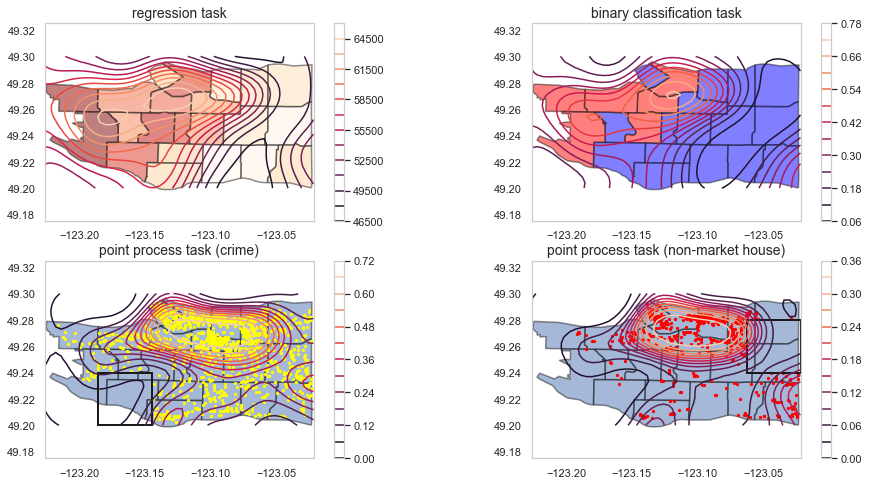

In [34]:
x_pre_crs,y_pre_crs = np.meshgrid(*[(np.linspace(0,X[0],num_pre[0])/100*(123.226-123.022)-123.226).reshape(-1,1),\
            (np.linspace(0,X[1],num_pre[1])/50*(49.30-49.20)+49.20).reshape(-1,1)],indexing='ij') # scale back to latitute and longtitute
x_pp_miss_crs=[np.array([x_pp_miss[i][:,0]/100*(123.226-123.022)-123.226,x_pp_miss[i][:,1]/50*(49.30-49.20)+49.20]).T \
               for i in range(len(x_pp_miss))]  # scale back to latitute and longtitute
gaps_x_crs=gaps[:,:,0].T/100*(123.226-123.022)-123.226
gaps_y_crs=gaps[:,:,1].T/50*(49.30-49.20)+49.20
gaps_crs=np.array([gaps_x_crs,gaps_y_crs]).T  # scale back to latitute and longtitute

fig=plt.figure(1,figsize=(16,8))
axs=plt.subplot(221)
vancouver.plot(column= 'income',ax = axs, alpha=0.5, edgecolor='k',legend=False,cmap='OrRd',linewidth=1.5)
axs.set_ylim([49.175, 49.325])
# cx.add_basemap(axs, crs=vancouver.crs)
CS=axs.contour(x_pre_crs, y_pre_crs, y_2D_est_reg_income.reshape(num_pre),levels=12)
CB = plt.colorbar(CS)
axs.set_title('regression task',fontsize=14)
plt.locator_params(axis="x",nbins=6)

axs=plt.subplot(222)
vancouver.plot(ax = axs, column= 'education', alpha=0.5, scheme='equal_interval', k=2, edgecolor='k',cmap='bwr',linewidth=1.5,\
  legend=False, legend_kwds={'loc': 'upper left','fontsize': 14})
axs.set_ylim([49.175, 49.325])
# cx.add_basemap(axs, crs=vancouver.crs)
CS=axs.contour(x_pre_crs, y_pre_crs, y_2D_est_cla.reshape(num_pre),levels=12)
CB = plt.colorbar(CS)
axs.set_title('binary classification task',fontsize=14)
plt.locator_params(axis="x",nbins=6)

axs=plt.subplot(223)
vancouver.plot(ax = axs, alpha=0.5, edgecolor='k',linewidth=1.5)
axs.set_ylim([49.175, 49.325])
# cx.add_basemap(axs, crs=vancouver.crs)
axs.scatter(x_pp_miss_crs[0][:,0],x_pp_miss_crs[0][:,1],color='yellow',s=5)
rect = patches.Rectangle(gaps_crs[0][0], (gaps_crs[0][1]-gaps_crs[0][0])[0], (gaps_crs[0][1]-gaps_crs[0][0])[1],\
                         linewidth=2, edgecolor='k', facecolor='none')
axs.add_patch(rect)
CS=axs.contour(x_pre_crs, y_pre_crs, y_2D_est_pp[0].reshape(num_pre),levels=12)
CB = plt.colorbar(CS)
axs.set_title('point process task (crime)',fontsize=14)
plt.locator_params(axis="x",nbins=6)

axs=plt.subplot(224)
vancouver.plot(ax = axs, alpha=0.5, edgecolor='k',linewidth=1.5)
axs.set_ylim([49.175, 49.325])
# cx.add_basemap(axs, crs=vancouver.crs)
axs.scatter(x_pp_miss_crs[1][:,0],x_pp_miss_crs[1][:,1],color='red',s=5)
rect = patches.Rectangle(gaps_crs[1][0], (gaps_crs[1][1]-gaps_crs[1][0])[0], (gaps_crs[1][1]-gaps_crs[1][0])[1],\
                         linewidth=2, edgecolor='k', facecolor='none')
axs.add_patch(rect)
CS=axs.contour(x_pre_crs, y_pre_crs, y_2D_est_pp[1].reshape(num_pre),levels=12)
CB = plt.colorbar(CS)
axs.set_title('point process task (non-market house)',fontsize=14)
plt.locator_params(axis="x",nbins=6)
plt.show()